In [1]:
import os
import time
import sys

sys.path.append("../")

import cv2
import numpy as np
from pwc_net import compute_pwcnet
#from opticalflow import compute_pyflow, compute_lukas_kanade
from OpticalFlowToolkit.lib import flowlib

from compute_metric import calculate_msen, calculate_pepn
#from block_matching import compute_block_matching

ERROR_THRESH = 3

In [4]:
#https://github.com/philferriere/tfoptflow
from tfoptflow.tfoptflow.model_pwcnet import ModelPWCNet, _DEFAULT_PWCNET_TEST_OPTIONS
from tfoptflow.tfoptflow.visualize import display_img_pairs_w_flows
import matplotlib.pyplot as plt
import cv2

def flow_to_img(flow, normalize=True, info=None, flow_mag_max=None):
    """Convert flow to viewable image, using color hue to encode flow vector orientation, and color saturation to
    encode vector length. This is similar to the OpenCV tutorial on dense optical flow, except that they map vector
    length to the value plane of the HSV color model, instead of the saturation plane, as we do here.
    Args:
        flow: optical flow
        normalize: Normalize flow to 0..255
        info: Text to superimpose on image (typically, the epe for the predicted flow)
        flow_mag_max: Max flow to map to 255
    Returns:
        img: viewable representation of the dense optical flow in RGB format
        flow_avg: optionally, also return average flow magnitude
    Ref:
        - OpenCV 3.0.0-dev documentation » OpenCV-Python Tutorials » Video Analysis »
        https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html
    """
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    flow_magnitude, flow_angle = cv2.cartToPolar(flow[..., 0].astype(np.float32), flow[..., 1].astype(np.float32))

    # A couple times, we've gotten NaNs out of the above...
    nans = np.isnan(flow_magnitude)
    if np.any(nans):
        nans = np.where(nans)
        flow_magnitude[nans] = 0.

    # Normalize
    hsv[..., 0] = flow_angle * 180 / np.pi / 2
    if normalize is True:
        if flow_mag_max is None:
            hsv[..., 1] = cv2.normalize(flow_magnitude, None, 0, 255, cv2.NORM_MINMAX)
        else:
            hsv[..., 1] = flow_magnitude * 255 / flow_mag_max
    else:
        hsv[..., 1] = flow_magnitude
    hsv[..., 2] = 255
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Add text to the image, if requested
    if info is not None:
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, info, (20, 20), font, 0.8, (0, 0, 0), 2, cv2.LINE_AA)

    return img

def plot_img_pairs_w_flows(
        img_pairs,
        flow_pyrs=None,
        num_lvls=0,
        flow_preds=None,
        flow_gts=None,
        titles=None,
        info=None,
        flow_mag_max=None):
    """Plot the given set of image pairs, optionally with flows and titles.
    Args:
        img_pairs: image pairs in [batch_size, 2, H, W, 3] or list([2, H, W, 3]) format.
        flow_pyrs: optional, predicted optical flow pyramids [batch_size, H, W, 2] or list([H, W, 2]) format.
        num_lvls: number of levels to show per pyramid (flow_pyrs must be set)
        flow_preds: optional, predicted flows in [batch_size, H, W, 2] or list([H, W, 2]) format.
        flow_gts: optional, groundtruth flows in [batch_size, H, W, 2] or list([H, W, 2]) format.
        titles: optional, list of image and flow IDs to display with each image.
        info: optional, stats to display above predicted flow
        flow_mag_max: Max flow to map to 255
    Returns:
        plt: plot
    """
    # Setup drawing canvas
    fig_height, fig_width = 5, 5
    row_count = len(img_pairs)
    col_count = 2
    #if flow_preds is not None:
    #    col_count += 1
    plt.figure(figsize=(fig_width * col_count, fig_height * row_count))

    # Plot img_pairs inside the canvas
    plot = 1
    for row in range(len(img_pairs)):
        # Plot image pair
        #plt.subplot(row_count, col_count, plot)
        #if titles is not None:
        #    plt.title(titles[row][0], fontsize=fig_width * 2)
        #plt.axis('off')
        #plt.imshow(img_pairs[row][0])
        #plt.subplot(row_count, col_count, plot + 1)
        if titles is not None:
            plt.title(titles[row][1], fontsize=fig_width * 2)
        plt.axis('off')
        plt.imshow(img_pairs[row][1])
        plot += 1

        # Plot predicted flow, if any
        if flow_preds is not None:
            plt.subplot(row_count, col_count, plot)
            title = "Lukas Kanade " + info[row] if info is not None else "PWC-NET"
            plt.title(title, fontsize=fig_width * 2)
            plt.axis('off')
            plt.imshow(flow_to_img(flow_preds[row], flow_mag_max=flow_mag_max))
            plot += 1

    plt.tight_layout()
    return plt

def display_img_pairs_w_flows(
        img_pairs,
        flow_preds=None,
        flow_gts=None,
        titles=None,
        info=None,
        flow_mag_max=None):
    """Display the given set of image pairs, optionally with flows and titles.
    Args:
        img_pairs: image pairs in [batch_size, 2, H, W, 3] or list([2, H, W, 3]) format.
        flow_preds: optional, predicted flows in [batch_size, H, W, 2] or list([H, W, 2]) format.
        flow_gts: optional, groundtruth flows in [batch_size, H, W, 2] or list([H, W, 2]) format.
        titles: optional, list of image and flow IDs to display with each image.
        info: optional, stats to display above predicted flow
        flow_mag_max: Max flow to map to 255
    """
    plt = plot_img_pairs_w_flows(img_pairs, None, 0, flow_preds, flow_gts, titles, info, flow_mag_max)
    plt.show()


def compute_pwcnet(img, img_prev):
    # Following the guide of https://github.com/philferriere/tfoptflow/blob/master/tfoptflow/pwcnet_eval_lg-6-2-multisteps-chairsthingsmix_flyingchairs.ipynb

    # Build a list of image pairs to process
    img_pairs = []
    img_pairs.append((img_prev, img))

    # Here, we're using a GPU (use '/device:CPU:0' to run inference on the CPU)
    gpu_devices = ['/device:CPU:0']  
    controller = '/device:CPU:0'

    ckpt_path = '/home/manelguz/mcv-m6-2023-team3/tfoptflow/tfoptflow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000'

    # Configure the model for inference, starting with the default options
    import copy
    nn_opts = copy.deepcopy(_DEFAULT_PWCNET_TEST_OPTIONS)
    nn_opts['verbose'] = True
    nn_opts['ckpt_path'] = ckpt_path
    nn_opts['batch_size'] = 1
    nn_opts['gpu_devices'] = gpu_devices
    nn_opts['controller'] = controller

    # We're running the PWC-Net-large model in quarter-resolution mode
    # That is, with a 6 level pyramid, and upsampling of level 2 by 4 in each dimension as the final flow prediction
    nn_opts['use_dense_cx'] = True
    nn_opts['use_res_cx'] = True
    nn_opts['pyr_lvls'] = 6
    nn_opts['flow_pred_lvl'] = 2

    # The size of the images in this dataset are not multiples of 64, while the model generates flows padded to multiples
    # of 64. Hence, we need to crop the predicted flows to their original size
    nn_opts['adapt_info'] = (1, 436, 1024, 2)

    # Instantiate the model in inference mode and display the model configuration
    nn = ModelPWCNet(mode='test', options=nn_opts)
    nn.print_config()

    pred_labels = np.array(nn.predict_from_img_pairs(img_pairs, batch_size=1))
    print(np.shape(pred_labels))
    display_img_pairs_w_flows(img_pairs, pred_labels)
    return pred_labels

Reading 376 x 1241 flow file in .png format
Building model...
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
... model built.
Loading model checkpoint /home/manelguz/mcv-m6-2023-team3/tfoptflow/tfoptflow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000 for eval or testing...

INFO:tensorflow:Restoring parameters from /home/manelguz/mcv-m6-2023-team3/tfoptflow/tfoptflow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
... model loaded

Model Configuration:
  verbose                True
  ckpt_path              /home/manelguz/mcv-m6-2023-team3/tfoptflow/tfoptflow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
  x_dtype                <dtype: 'float32'>
  x_shape                [2, None, None, 3]
  y_dtype                <dtype: 'float32'>
  y_shape                [None, None, 2]
  gpu_devices            ['/device:CPU:0']
  controller             /device:CPU:0
  batch_size             1
  use_tf_data

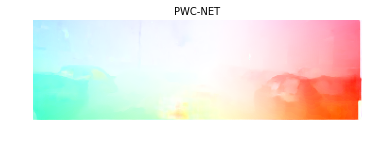

/home/manelguz/mcv-m6-2023-team3/w4/plot_data.py:11: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/manelguz/miniconda3/envs/tfopenflow2/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/manelguz/miniconda3/envs/tfopenflow2/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/manelguz/miniconda3/envs/tfopenflow2/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/manelguz/miniconda3/envs/tfopenflow2/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/manelguz/miniconda3/envs/tfopenfl

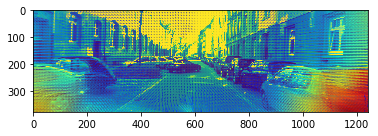

Elapsed time: 7.09 seconds


In [5]:

import time
start_time = time.time()

method = 'epic'
def read_img(color="gray"):
    if color == "gray":
        img_prev = cv2.imread('../data_w1/img/000045_10.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.imread('../data_w1/img/000045_11.png', cv2.IMREAD_GRAYSCALE)
    elif color == "rgb":
        img_prev = cv2.imread('../data_w1/img_color/000045_10.png')
        img_prev = cv2.cvtColor(img_prev, cv2.COLOR_BGR2RGB)
        img = cv2.imread('../data_w1/img_color/000045_11.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        raise NotImplementedError
    
    return img, img_prev

gt_flow = flowlib.read_flow('../data_w1/flow_noc/000045_10.png')

if method == 'pyflow':
    img, img_prev = read_img(color="gray")
    pred_flow = compute_pyflow(img, img_prev)

elif method == 'kanade':
    img, img_prev = read_img(color="gray")
    pred_flow = compute_lukas_kanade(img, img_prev)
elif method == 'epic':
    img, img_prev = read_img(color="rgb")
    pred_flow = compute_pwcnet(img, img_prev).squeeze()
    from plot_data import plot_3D, plot_optical_flow
    img, img_prev = read_img(color="gray")
    plot_optical_flow(img, pred_flow)


# Record the current time again
end_time = time.time()

# Calculate the difference in seconds
elapsed_time = end_time - start_time

print("Elapsed time: {:.2f} seconds".format(elapsed_time))
    

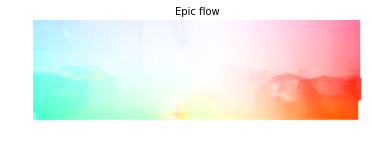

In [41]:
import matplotlib.pyplot as plt

def flow_to_img(flow, normalize=True, info=None, flow_mag_max=None):
    """Convert flow to viewable image, using color hue to encode flow vector orientation, and color saturation to
    encode vector length. This is similar to the OpenCV tutorial on dense optical flow, except that they map vector
    length to the value plane of the HSV color model, instead of the saturation plane, as we do here.
    Args:
        flow: optical flow
        normalize: Normalize flow to 0..255
        info: Text to superimpose on image (typically, the epe for the predicted flow)
        flow_mag_max: Max flow to map to 255
    Returns:
        img: viewable representation of the dense optical flow in RGB format
        flow_avg: optionally, also return average flow magnitude
    Ref:
        - OpenCV 3.0.0-dev documentation » OpenCV-Python Tutorials » Video Analysis »
        https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html
    """
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    flow_magnitude, flow_angle = cv2.cartToPolar(flow[..., 0].astype(np.float32), flow[..., 1].astype(np.float32))

    # A couple times, we've gotten NaNs out of the above...
    nans = np.isnan(flow_magnitude)
    if np.any(nans):
        nans = np.where(nans)
        flow_magnitude[nans] = 0.

    # Normalize
    hsv[..., 0] = flow_angle * 180 / np.pi / 2
    if normalize is True:
        if flow_mag_max is None:
            hsv[..., 1] = cv2.normalize(flow_magnitude, None, 0, 255, cv2.NORM_MINMAX)
        else:
            hsv[..., 1] = flow_magnitude * 255 / flow_mag_max
    else:
        hsv[..., 1] = flow_magnitude
    hsv[..., 2] = 255
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Add text to the image, if requested
    if info is not None:
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, info, (20, 20), font, 0.8, (0, 0, 0), 2, cv2.LINE_AA)

    return img

def plot_img_pairs_w_flows(
        img_pairs,
        flow_pyrs=None,
        num_lvls=0,
        flow_preds=None,
        flow_gts=None,
        titles=None,
        info=None,
        flow_mag_max=None):
    """Plot the given set of image pairs, optionally with flows and titles.
    Args:
        img_pairs: image pairs in [batch_size, 2, H, W, 3] or list([2, H, W, 3]) format.
        flow_pyrs: optional, predicted optical flow pyramids [batch_size, H, W, 2] or list([H, W, 2]) format.
        num_lvls: number of levels to show per pyramid (flow_pyrs must be set)
        flow_preds: optional, predicted flows in [batch_size, H, W, 2] or list([H, W, 2]) format.
        flow_gts: optional, groundtruth flows in [batch_size, H, W, 2] or list([H, W, 2]) format.
        titles: optional, list of image and flow IDs to display with each image.
        info: optional, stats to display above predicted flow
        flow_mag_max: Max flow to map to 255
    Returns:
        plt: plot
    """
    # Setup drawing canvas
    fig_height, fig_width = 5, 5
    row_count = len(img_pairs)
    col_count = 2
    #if flow_preds is not None:
    #    col_count += 1
    plt.figure(figsize=(fig_width * col_count, fig_height * row_count))

    # Plot img_pairs inside the canvas
    plot = 1
    for row in range(len(img_pairs)):
        # Plot image pair
        #plt.subplot(row_count, col_count, plot)
        #if titles is not None:
        #    plt.title(titles[row][0], fontsize=fig_width * 2)
        #plt.axis('off')
        #plt.imshow(img_pairs[row][0])
        #plt.subplot(row_count, col_count, plot + 1)
        if titles is not None:
            plt.title(titles[row][1], fontsize=fig_width * 2)
        plt.axis('off')
        plt.imshow(img_pairs[row][1])
        plot += 1

        # Plot predicted flow, if any
        if flow_preds is not None:
            plt.subplot(row_count, col_count, plot)
            title = "Epic flow " + info[row] if info is not None else "Epic flow"
            plt.title(title, fontsize=fig_width * 2)
            plt.axis('off')
            plt.imshow(flow_to_img(flow_preds[row], flow_mag_max=flow_mag_max))
            plot += 1

    plt.tight_layout()
    return plt

def display_img_pairs_w_flows(
        img_pairs,
        flow_preds=None,
        flow_gts=None,
        titles=None,
        info=None,
        flow_mag_max=None):
    """Display the given set of image pairs, optionally with flows and titles.
    Args:
        img_pairs: image pairs in [batch_size, 2, H, W, 3] or list([2, H, W, 3]) format.
        flow_preds: optional, predicted flows in [batch_size, H, W, 2] or list([H, W, 2]) format.
        flow_gts: optional, groundtruth flows in [batch_size, H, W, 2] or list([H, W, 2]) format.
        titles: optional, list of image and flow IDs to display with each image.
        info: optional, stats to display above predicted flow
        flow_mag_max: Max flow to map to 255
    """
    plt = plot_img_pairs_w_flows(img_pairs, None, 0, flow_preds, flow_gts, titles, info, flow_mag_max)
    plt.show()

img_pairs = []
img_pairs.append((img_prev, img))
display_img_pairs_w_flows(img_pairs, pred_flow)